In [35]:
import sys

In [36]:
from operator import add
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
import pandas as pd
import os
import glob
import wordcloud
from pyspark.sql.functions import *

In [37]:
spark = SparkSession\
.builder\
.appName("Wordcount")\
.getOrCreate()

In [38]:
path = './dataset_lyrics/'
all_files = glob.glob(os.path.join(path, "data_lyrics*.csv"))
all_files

['./dataset_lyrics/data_lyrics5.csv',
 './dataset_lyrics/data_lyrics6.csv',
 './dataset_lyrics/data_lyrics7.csv',
 './dataset_lyrics/data_lyrics3.csv',
 './dataset_lyrics/data_lyrics1.csv',
 './dataset_lyrics/data_lyrics9.csv',
 './dataset_lyrics/data_lyrics10.csv',
 './dataset_lyrics/data_lyrics8.csv',
 './dataset_lyrics/data_lyrics2.csv',
 './dataset_lyrics/data_lyrics4.csv']

In [39]:

data = spark.read.format('csv').options(header='true', inferSchema='true').load(all_files)
data.show()

+----+--------------------+--------------------+----+--------------------+------+
|Rank|                Song|              Artist|Year|              Lyrics|Source|
+----+--------------------+--------------------+----+--------------------+------+
|  39| somewhere out there|linda ronstadt an...|1987| somewhere out th...|     1|
|  40|   land of confusion|             genesis|1987| i mustve dreamed...|     1|
|  41|       jacobs ladder|huey lewis and th...|1987|i met a fan dance...|     3|
|  42|      whos that girl|             madonna|1987| whos that girl w...|     1|
|  43|      you got it all|            the jets|1987| i i was a game h...|     1|
|  44|touch me i want y...|        samantha fox|1987| ah touch me this...|     1|
|  45|i just cant stop ...|michael jackson w...|1987| each time the wi...|     1|
|  46| causing a commotion|             madonna|1987| ive got the move...|     1|
|  47|         in too deep|             genesis|1987| all that time i ...|     1|
|  48|    lets w

In [40]:
data = data.withColumn('Lyrics', trim(data.Lyrics))
data.show()

+----+--------------------+--------------------+----+--------------------+------+
|Rank|                Song|              Artist|Year|              Lyrics|Source|
+----+--------------------+--------------------+----+--------------------+------+
|  39| somewhere out there|linda ronstadt an...|1987|somewhere out the...|     1|
|  40|   land of confusion|             genesis|1987|i mustve dreamed ...|     1|
|  41|       jacobs ladder|huey lewis and th...|1987|i met a fan dance...|     3|
|  42|      whos that girl|             madonna|1987|whos that girl wh...|     1|
|  43|      you got it all|            the jets|1987|i i was a game he...|     1|
|  44|touch me i want y...|        samantha fox|1987|ah touch me this ...|     1|
|  45|i just cant stop ...|michael jackson w...|1987|each time the win...|     1|
|  46| causing a commotion|             madonna|1987|ive got the moves...|     1|
|  47|         in too deep|             genesis|1987|all that time i w...|     1|
|  48|    lets w

In [41]:
data.withColumn('word', f.explode(f.split(f.col('Lyrics'), ' '))) \
  .groupBy('word') \
  .count() \
  .sort('count', ascending=False) \
  .show(10)

+----+-----+
|word|count|
+----+-----+
| you|64606|
|   i|56466|
| the|53451|
|  to|35752|
| and|32555|
|  me|31170|
|   a|29282|
|  it|25688|
|  my|22821|
|  in|18553|
+----+-----+
only showing top 10 rows



In [42]:
tokenizer = Tokenizer(inputCol="Lyrics", outputCol="words_token")
tokenized = tokenizer.transform(data).select('Rank','words_token')
tokenized.show()

+----+--------------------+
|Rank|         words_token|
+----+--------------------+
|  39|[somewhere, out, ...|
|  40|[i, mustve, dream...|
|  41|[i, met, a, fan, ...|
|  42|[whos, that, girl...|
|  43|[i, i, was, a, ga...|
|  44|[ah, touch, me, t...|
|  45|[each, time, the,...|
|  46|[ive, got, the, m...|
|  47|[all, that, time,...|
|  48|[theres, somethin...|
|  49|[i, used, to, be,...|
|  50|[take, me, as, i,...|
|  51|[if, i, could, tu...|
|  52|[my, name, is, lu...|
|  53|[who, needs, frie...|
|  54|[welcome, to, the...|
|  55|                  []|
|  56|[when, lights, go...|
|  57|[pay, attention, ...|
|  58|[como, puede, ser...|
+----+--------------------+
only showing top 20 rows



In [43]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
data_clean = remover.transform(tokenized).select('Rank', 'words_clean')
data_clean.show()

+----+--------------------+
|Rank|         words_clean|
+----+--------------------+
|  39|[somewhere, benea...|
|  40|[mustve, dreamed,...|
|  41|[met, fan, dancer...|
|  42|[whos, girl, whos...|
|  43|[game, play, brou...|
|  44|[ah, touch, night...|
|  45|[time, wind, blow...|
|  46|[ive, got, moves,...|
|  47|[time, searching,...|
|  48|[theres, somethin...|
|  49|[used, renegade, ...|
|  50|[take, put, hand,...|
|  51|[turn, page, time...|
|  52|[name, luka, live...|
|  53|[needs, friends, ...|
|  54|[welcome, big, ti...|
|  55|                  []|
|  56|[lights, go, see,...|
|  57|[pay, attention, ...|
|  58|[como, puede, ser...|
+----+--------------------+
only showing top 20 rows



In [44]:
result = data_clean.withColumn('word', f.explode(f.col('words_clean'))) \
  .filter("word <> '  '")\
  .groupBy('word') \
  .count().sort('count', ascending=False) 
result.show(10)

+-----+-----+
| word|count|
+-----+-----+
| love|15283|
|   im|14278|
| dont|11587|
| know|11166|
| like|10949|
|   oh| 9736|
| baby| 9098|
|  got| 8289|
|  get| 8265|
|youre| 6592|
+-----+-----+
only showing top 10 rows



In [14]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_files ])
combined_csv.to_csv( "combined_csv.csv", index=False )

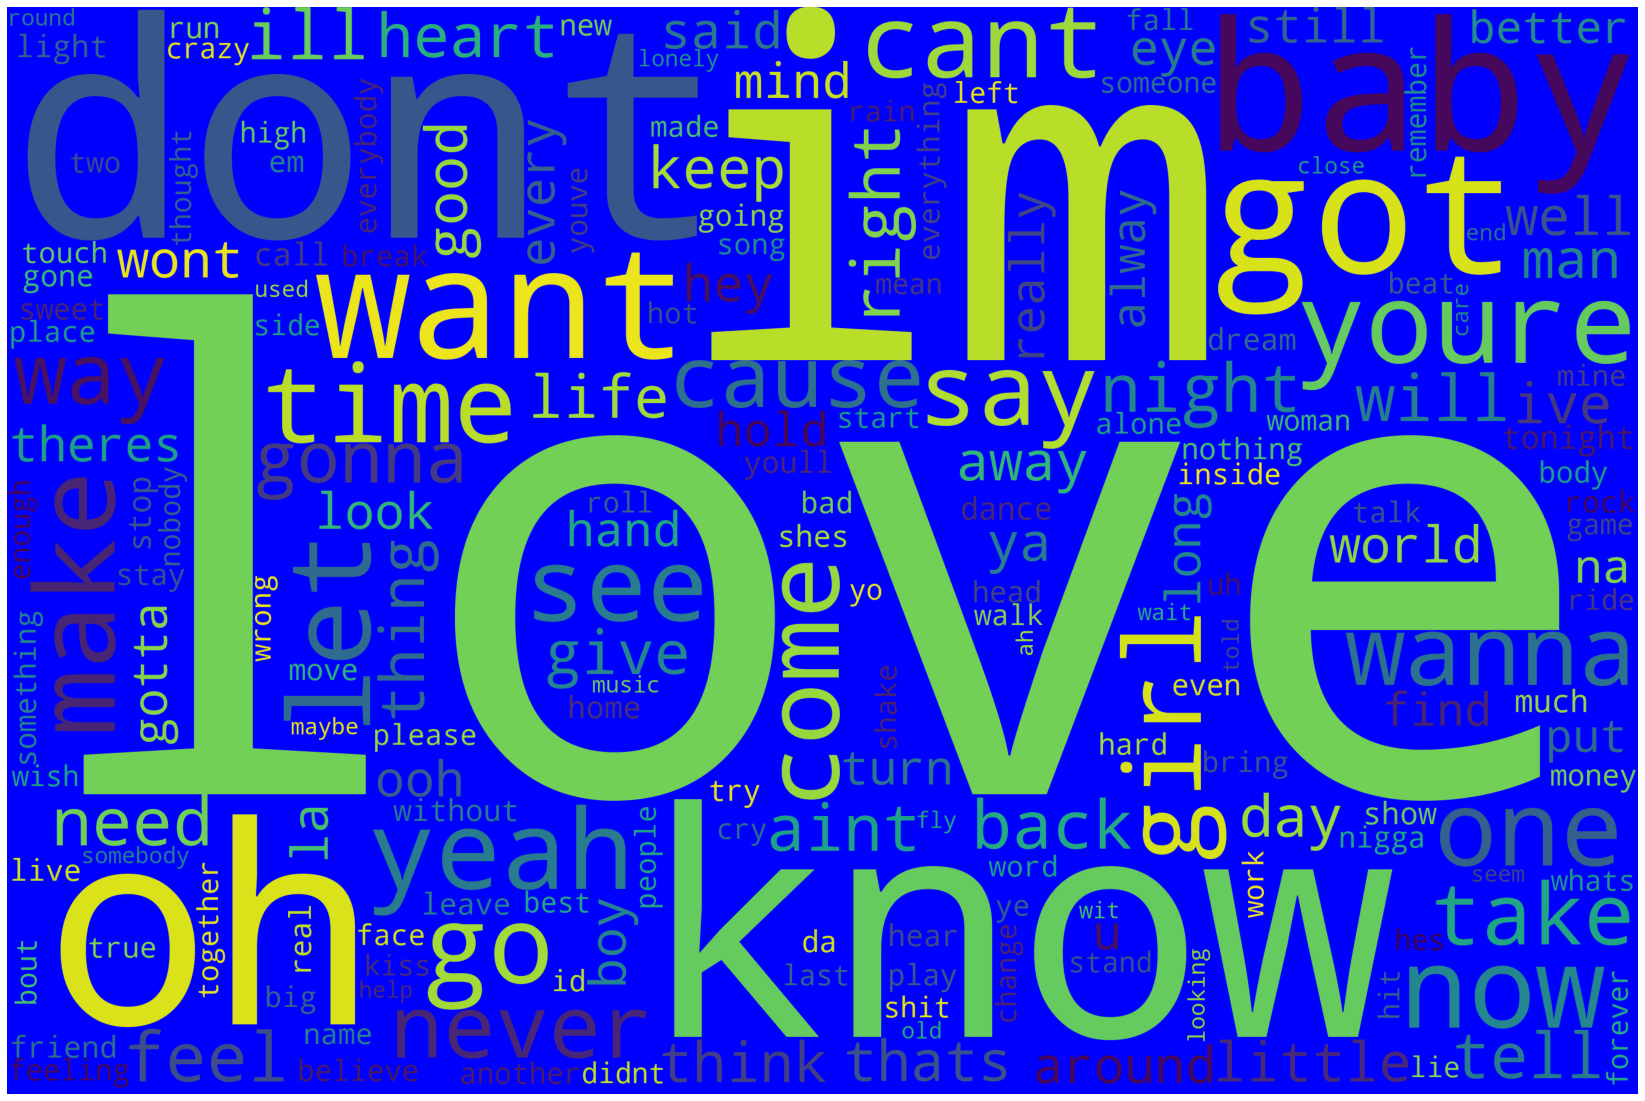

In [45]:
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
lyrics = pd.read_csv('combined_csv.csv', sep=',')
text = amazone.Lyrics.to_json()
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(30, 20))

plt.imshow(wordcloud) 

plt.axis("off")
plt.show()